<a href="https://colab.research.google.com/github/RafaelAndrade55/Aula_4_Alura/blob/main/previsao_decoque_googledrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Pirometria 11F07.xlsx to Pirometria 11F07.xlsx
Digite a temperatura limite de decoque (°C): 1050

Duração Média da Campanha do Forno: 81.7 dias


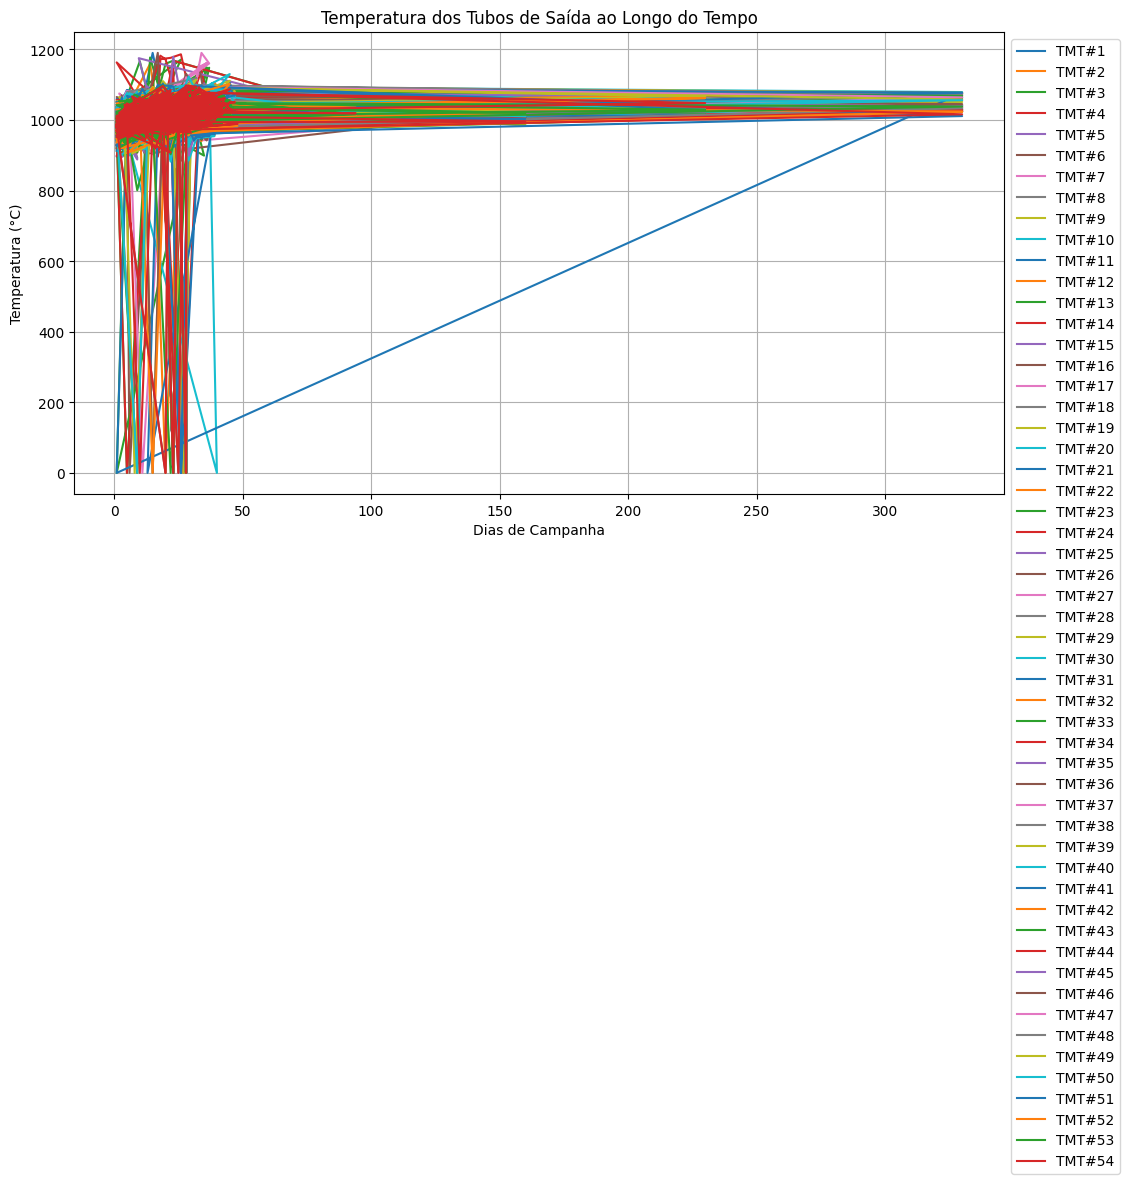

Mounted at /content/drive

Resultados salvos em 'previsao_decoque.csv' na mesma pasta do arquivo de entrada e gráfico gerado.


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive

def prever_decoque(df, T_limite, nome_arquivo_saida):
  """
  Preve a necessidade de decoque e salva as previsões em um arquivo CSV.

  Args:
    df (pandas.DataFrame): DataFrame com os dados de temperatura.
    T_limite (float): Temperatura limite que indica a necessidade de decoque (°C).
    nome_arquivo_saida (str): Nome do arquivo CSV de saída.

  Returns:
    None: Imprime as previsões e gera gráficos.
  """

  # Remover linhas com 'Run (days)' igual a 0 (inicio de campanha)
  df = df[df['Run (days)'] != 0]

  # Calcular a taxa média de aumento de temperatura para cada tubo
  taxas_aumento_tubo = {}
  for coluna in df.columns[4:]:  # Iterar pelas colunas de temperatura (TMT#1 - TMT#54)
    tubo = coluna.split('#')[1]

    # Criar modelo de regressão linear
    modelo = LinearRegression()

    # Extrair dados de temperatura e dias de campanha, ignorando valores 0
    x = df['Run (days)'][df[coluna] != 0].values.reshape(-1, 1)
    y = df[coluna][df[coluna] != 0].values.reshape(-1, 1)

    # Treinar o modelo
    modelo.fit(x, y)

    # Armazenar a taxa de aumento (coeficiente angular da reta)
    taxas_aumento_tubo[tubo] = modelo.coef_[0][0]

  # Calcular a taxa média de aumento de temperatura global do forno
  taxa_aumento_global = np.mean(list(taxas_aumento_tubo.values()))

  # Previsão da duração da campanha para cada tubo e salvar em um DataFrame
  dados_saida = []
  for tubo, taxa in taxas_aumento_tubo.items():
    T_inicial = df[f'TMT#{tubo}'].iloc[-1]  # Temperatura mais recente do tubo
    if T_inicial != 0:
      t_campanha = (T_limite - T_inicial) / taxa
      dados_saida.append({'Tubo': tubo, 'Taxa de Aumento (°C/dia)': taxa, 'Duração da Campanha (dias)': t_campanha})
  df_saida = pd.DataFrame(dados_saida)

  # Calcular a duração média da campanha do forno
  duracao_media_campanha = (T_limite - df.iloc[:, 4:].mean().mean()) / taxa_aumento_global
  print("\nDuração Média da Campanha do Forno:", f"{duracao_media_campanha:.1f} dias")

  # Adicionar a duração média da campanha ao DataFrame de saída
  df_saida.loc[len(df_saida)] = {'Tubo': 'Média Global', 'Taxa de Aumento (°C/dia)': taxa_aumento_global, 'Duração da Campanha (dias)': duracao_media_campanha}

  # Plotar gráfico da temperatura dos tubos em função do tempo
  plt.figure(figsize=(12, 6))
  for coluna in df.columns[4:]:
    plt.plot(df['Run (days)'], df[coluna], label=coluna)
  plt.xlabel('Dias de Campanha')
  plt.ylabel('Temperatura (°C)')
  plt.title('Temperatura dos Tubos de Saída ao Longo do Tempo')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.grid(True)
  plt.show()

  # Salvar o DataFrame de saída como um arquivo CSV na mesma pasta do arquivo de entrada
  drive.mount('/content/drive')
  caminho_pasta = '/'.join(nome_arquivo.split('/')[:-1])
  df_saida.to_csv(f'/content/drive/My Drive/{caminho_pasta}/{nome_arquivo_saida}', index=False)

# Solicitar o upload do arquivo Excel do Google Drive
uploaded = files.upload()

# Obter o nome do arquivo
nome_arquivo = list(uploaded.keys())[0]

# Carregar o arquivo Excel em um DataFrame
df = pd.read_excel(nome_arquivo)

# Solicitar a temperatura limite para o usuário
T_limite = float(input("Digite a temperatura limite de decoque (°C): "))

# Nome do arquivo de saída
nome_arquivo_saida = 'previsao_decoque.csv'

# Executar a previsão de decoque
prever_decoque(df, T_limite, nome_arquivo_saida)

print("\nResultados salvos em 'previsao_decoque.csv' na mesma pasta do arquivo de entrada e gráfico gerado.")